<a href="https://colab.research.google.com/github/Vector42-rev/learning_to_make_machine_learn/blob/lab_stuff/ML_LAB_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
A1. Evaluate the intraclass spread and interclass distances between the classes in your dataset. If your data deals with multiple classes, you can take any two classes.
 Steps below (refer below diagram for understanding):
•
Calculate the mean for each class (also called as class centroid) (Suggestion: You may use numpy.mean() function for finding the average vector for all vectors in a
given class. Please define the axis property appropriately to use this function. EX: feat_vecs.mean(axis=0))
•
Calculate spread (standard deviation) for each class (Suggestion: You may use numpy.std() function for finding the standard deviation vector for
all vectors in a given class. Please define the axis property appropriately to use this function.)
•
Calculate the distance between mean vectors between classes (Suggestion: numpy.linalg.norm(centroid1 – centroid2) gives the Euclidean distance between two centroids.)
"""


In [1]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_excel('/content/drive/MyDrive/ML/lab4/team_1_to_5.xlsx')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply the function to the questions and answers columns
df['questions_embeddings'] = df['questions'].apply(get_bert_embeddings)
df['answers_embeddings'] = df['answers'].apply(get_bert_embeddings)

# Combine question and answer embeddings
df['combined_embeddings'] = df.apply(lambda row: np.concatenate((row['questions_embeddings'], row['answers_embeddings'])), axis=1)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
#MEAN FOR EACH CLASS (CLASS CENTRIOD)
def calculate_mean_embeddings(group):
    return np.mean(np.vstack(group), axis=0)

mean_embeddings = df.groupby('confidence')['combined_embeddings'].apply(calculate_mean_embeddings)
mean_embeddings_df = pd.DataFrame(mean_embeddings).reset_index()

In [8]:
print(mean_embeddings_df)

   confidence                                combined_embeddings
0           0  [0.07426818, -0.17169052, 0.076299146, -0.0854...
1           1  [0.07271235, -0.16657194, 0.07885453, -0.12241...


In [16]:
#INTERCLASS SPREAD (OR STANDARD DEVIATION)

def calculate_std_embeddings(group):
    return np.std(np.vstack(group), axis=0)

std_embeddings = df.groupby('confidence')['combined_embeddings'].apply(calculate_std_embeddings)
std_embeddings_df = pd.DataFrame(std_embeddings).reset_index()
print(std_embeddings_df)

   confidence                                combined_embeddings
0           0  [0.1843168, 0.20508498, 0.24117973, 0.14113545...
1           1  [0.20678782, 0.24360344, 0.25497288, 0.1614048...


In [17]:
#INTERCLASS DISTANCE
print(np.linalg.norm(np.array(mean_embeddings_df['combined_embeddings'][0])-np.array(mean_embeddings_df['combined_embeddings'][1])))

1.7700518


In [2]:

X = np.vstack(df['combined_embeddings'])
y = df['confidence'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [5]:
print(knn.score(X_test,y_test))


0.5757575757575758


In [7]:
X = np.vstack(df['combined_embeddings'])
y = df['confidence'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [8]:
print(knn.score(X_test,y_test))


0.696969696969697


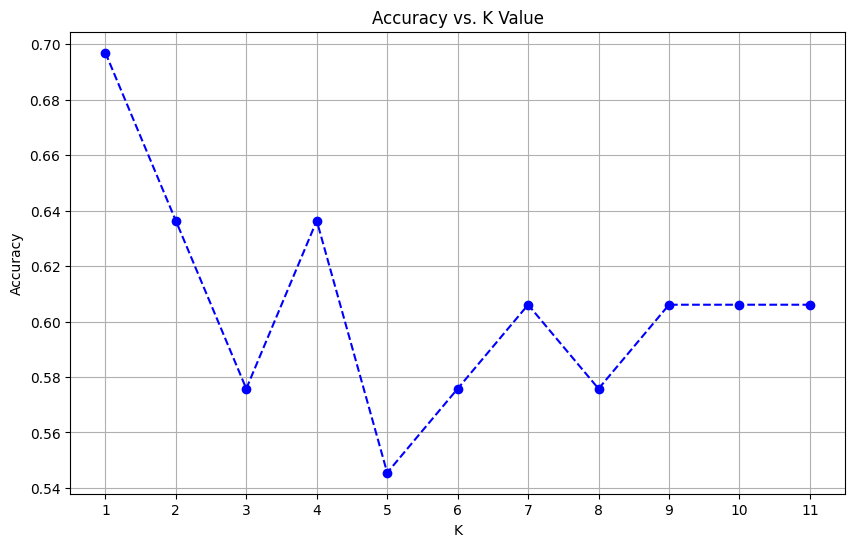

In [16]:
"""
A8. Make k = 1 to implement NN classifier and compare the results with kNN (k = 3). Vary k from 1 to 11 and make an accuracy plot.
"""

import matplotlib.pyplot as plt
accuracies=[]
k_values=range(1,12)
for k in k_values:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  out1=knn.score(X_test,y_test)
  accuracies.append(out1)

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='--', color='b')
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [17]:

def predict_labels(question, answer):
    q_embedding = get_bert_embeddings(question)
    a_embedding = get_bert_embeddings(answer)
    combined_embedding = np.concatenate((q_embedding, a_embedding)).reshape(1, -1)
    return knn.predict(combined_embedding)


new_question = "What is machine learning?"
new_answer = "It is the process by which a machine learns."
prediction = predict_labels(new_question, new_answer)
print(f'Predicted confidence: {prediction[0]}')

Predicted confidence: 1


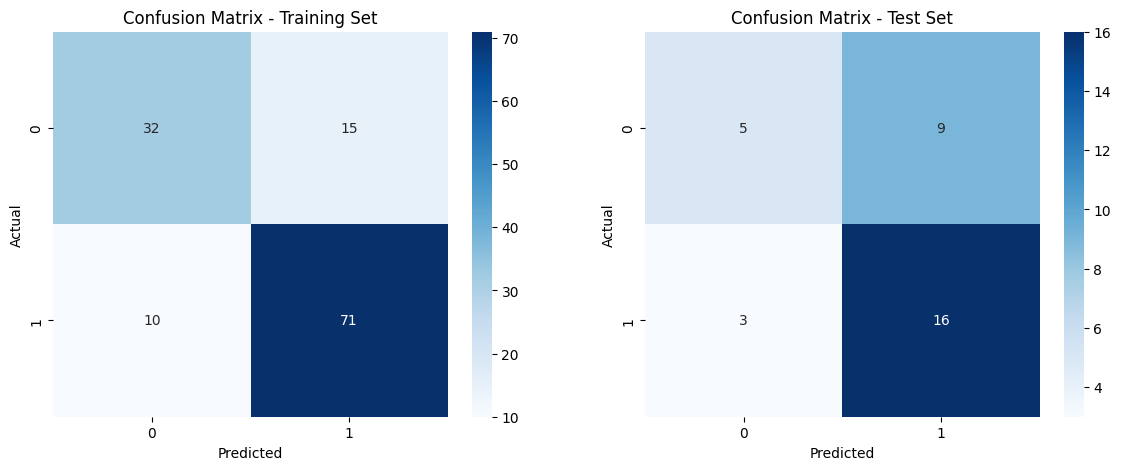

Training Precision: 0.80
Training Recall: 0.80
Training F1-Score: 0.80
Test Precision: 0.63
Test Recall: 0.64
Test F1-Score: 0.61


In [19]:
"""
A9. Please evaluate confusion matrix for your classification problem. From confusion matrix, the other performance metrics such as precision, recall and F1-Score
measures for both training and test data. Based on your observations, infer the models learning outcome (underfit / regularfit / overfit).
"""
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score
import seaborn as sns


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Training Set')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix - Test Set')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.show()

precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')


precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("Training Precision: {:.2f}".format(precision_train))
print("Training Recall: {:.2f}".format(recall_train))
print("Training F1-Score: {:.2f}".format(f1_train))

print("Test Precision: {:.2f}".format(precision_test))
print("Test Recall: {:.2f}".format(recall_test))
print("Test F1-Score: {:.2f}".format(f1_test))

```
THE MODEL(K=4) IS LIKELY OVERFITTING. AS THE MODEL'S PERFORMANCE OF TESTING DATA DROPPED.IT HAS LEARNT THE TRAINING DATA TOO WELL, INCLUDING POTENTIALLY IRRELVANT DETAILS, AS A RESULT DOESN'T PERFORM WELL ON UNSEEN DATA.
```